In [ ]:
#   bem: triangulation and fmm/bem electrostatics tools 
#
#   Copyright (C) 2011-2012 Robert Jordens <jordens@gmail.com>
#
#   This program is free software: you can redistribute it and/or modify
#   it under the terms of the GNU General Public License as published by
#   the Free Software Foundation, either version 3 of the License, or
#   (at your option) any later version.
#
#   This program is distributed in the hope that it will be useful,
#   but WITHOUT ANY WARRANTY; without even the implied warranty of
#   MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
#   GNU General Public License for more details.
#
#   You should have received a copy of the GNU General Public License
#   along with this program.  If not, see <http://www.gnu.org/licenses/>.

# `bem` 3D electrostatics example

In [1]:
import sys
import logging, os
import numpy as np
import pyface.qt    # This is just for setting "Qt" sip API version to 2 before matplotlib sets it to default v1 that is incompatible with "pyside" in package "mayavi".
import matplotlib.pyplot as plt
from multiprocessing import Pool    # parallel computation.

sys.path.append('../../')   # add path of package "bem" to search list.

from bem import Electrodes, Sphere, Mesh, Grid, Configuration, Result
from bem.formats import stl

In [2]:
# base file name for outputs and inputs is the script name
try:
    # works only if we are a script
    prefix = os.path.splitext(__file__)[0]
except NameError:
    # fallback for notebooks
    prefix = "SimpleTrap"

In [3]:
### scale to natural units (ion height)
scale = 40e-6
use_stl = True

if not use_stl:
    # load electrode faces from loops
    ele = Electrodes.from_trap(open("%s.ele" % prefix), scale)
    # initial triangulation, area 20, quiet
    mesh = Mesh.from_electrodes(ele)
    mesh.triangulate(opts="qa10Q")
else:
    # load electrode faces from colored stl
    s = stl.read_stl(open("%s.stl" % prefix, "rb"))
    mesh = Mesh.from_mesh(stl.stl_to_mesh(*s, scale=scale/1e-6,
        rename={9495: "DC1", 17962: "DC3", 18994: "DC5",
        18869: "DC2", 20943: "RF", 18129: "DC4"}))

dropping 0


In [4]:
def run_job(args):
    job, grid, prefix = args
    # refine twice adaptively with increasing number of triangles, min
    # angle 25deg
    job.adapt_mesh(triangles=4e2, opts="q25Q")
    job.adapt_mesh(triangles=1e3, opts="q25Q")
    # solve for charges
    job.solve_singularities(num_lev=3)
    # get potentials and fields
    result = job.simulate(grid, field=job.name=="RF", num_lev=1)
    result.to_vtk(prefix)
    print "finished job %s" % job.name
    return job.collect_charges()

In [5]:
# set .1 max area within 3
mesh.areas_from_constraints(Sphere(center=np.array([0, 0, 1.]),    # areas_from_constraints specifies a region with finer mesh.
           radius=2, inside=.2, outside=10.))    # inside, outside assign the mesh density.
# retriangulate quality and quiet with areas
mesh.triangulate(opts="qQ", new=False)
# save base mesh to vtk
mesh.to_vtk(prefix)

/home/wwc/anaconda3/envs/bem27test3/lib/python2.7/site-packages/tvtk/array_handler.py:268: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


In [6]:
# grid to evalute potential and fields at
n, s = 2*60, 0.5
nx, ny, nz = n/2, int(n/2.5), n/3
sx, sy, sz = s, s, s                                                 # pay attention to s/2. not s/2
print "Shape", nx, ny, nz
print "Step", sx, sy, sz, "\n"
grid = Grid(center=(0, 0, 0), step=(sx, sy, sz), shape=(nx, ny, nz))    # shape: the calculation region
# generate electrode potential configurations to simulate
# use regexps to match electrode names
jobs = list(Configuration.select(mesh, "DC.*","RF"))    # select() is to 
# run the different electrodes on the parallel pool
#pmap = Pool().map # parallel map
pmap = map # serial map
pmap(run_job, ((job, grid, prefix) for job in jobs))

Shape 60 48 40
Step 0.5 0.5 0.5 

finished job DC1
finished job DC3
finished job DC5
finished job DC2
finished job RF
finished job DC4


[array([ 4.015966  , -0.94848454, -0.24906277, -0.07080647, -1.62394951,
        -0.12604093]),
 array([-0.90960094,  3.77296251, -0.07091635, -1.05589966, -0.4002636 ,
        -0.92416197]),
 array([-0.23048589, -0.06929706,  5.2529352 , -0.01437012, -4.38615935,
        -0.22866961]),
 array([-0.06896146, -1.10779123, -0.01434482,  1.40502098, -0.06110635,
        -0.06933333]),
 array([-1.43547759, -0.39233336, -4.35984025, -0.06154495, 10.41131813,
        -1.44504742]),
 array([-0.12591326, -0.9487168 , -0.24696988, -0.07081001, -1.6260726 ,
         4.01319566])]

/home/wwc/anaconda3/envs/bem27test3/lib/python2.7/site-packages/numpy/ma/core.py:6442: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/home/wwc/anaconda3/envs/bem27test3/lib/python2.7/site-packages/numpy/ma/core.py:6442: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


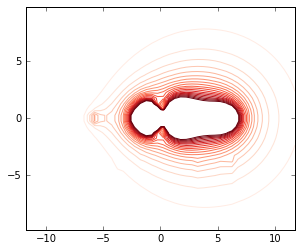

In [7]:
# isocontour plot of the RF pseudopotential radially
result = Result.from_vtk(prefix, "RF")
p = result.pseudo_potential    # p.shape is a tuple that stores the length of x, y, z, respectively.
x = grid.to_mgrid()[:, p.shape[0]/2]    # p.shape[0]/2 is in the middle of x. ?
p = p[p.shape[0]/2]    # get the slice of yz plain at x = p.shape[0]/2, the middle plain.
fig, ax = plt.subplots()
ax.set_aspect("equal")
ax.contour(x[1], x[2], p, levels=np.linspace(0, 2e-2, 20), cmap=plt.cm.Reds)

p max 1.3658
xy plane, RF pseudo


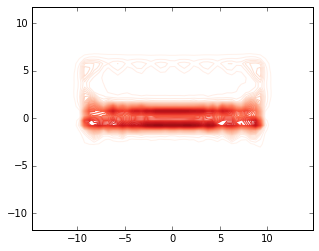

In [8]:
# isocontour plot of the RF pseudopotential radially wwc
result = Result.from_vtk(prefix, "RF")
p = result.pseudo_potential
maxp = np.amax(p)
print "p max", maxp
coord = grid.to_mgrid()
x = coord[:,:,:,p.shape[2]/2]
p = p[:,:,p.shape[2]/2]
print "xy plane, RF pseudo"
fig, ax = plt.subplots()
ax.set_aspect("equal")
ax.contour(x[0], x[1], p, levels=np.linspace(0, maxp, 50), cmap=plt.cm.Reds)

p max 0.936817
xy plane


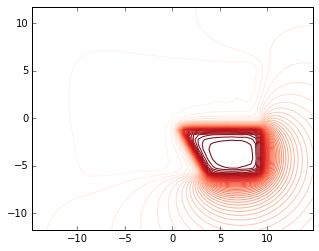

In [9]:
# isocontour plot of the DC potential
result = Result.from_vtk(prefix, "DC1")
praw = result.potential
maxp = np.amax(praw)
print "p max", maxp
coord = grid.to_mgrid()
x = coord[:,:,:,praw.shape[2]/2]
p = praw[:,:,praw.shape[2]/2]
print "xy plane"
fig, ax = plt.subplots()
ax.set_aspect("equal")
ax.contour(x[0], x[1], p, levels=np.linspace(0, maxp, 50), cmap=plt.cm.Reds) # xy plane should use x[0] and x[1]

In [10]:
print coord.shape
print coord[:,praw.shape[0]/2].shape    # slice at nx/2
coord

(3, 60, 48, 40)
(3, 48, 40)


array([[[[-14.75, -14.75, -14.75, ..., -14.75, -14.75, -14.75],
         [-14.75, -14.75, -14.75, ..., -14.75, -14.75, -14.75],
         [-14.75, -14.75, -14.75, ..., -14.75, -14.75, -14.75],
         ...,
         [-14.75, -14.75, -14.75, ..., -14.75, -14.75, -14.75],
         [-14.75, -14.75, -14.75, ..., -14.75, -14.75, -14.75],
         [-14.75, -14.75, -14.75, ..., -14.75, -14.75, -14.75]],

        [[-14.25, -14.25, -14.25, ..., -14.25, -14.25, -14.25],
         [-14.25, -14.25, -14.25, ..., -14.25, -14.25, -14.25],
         [-14.25, -14.25, -14.25, ..., -14.25, -14.25, -14.25],
         ...,
         [-14.25, -14.25, -14.25, ..., -14.25, -14.25, -14.25],
         [-14.25, -14.25, -14.25, ..., -14.25, -14.25, -14.25],
         [-14.25, -14.25, -14.25, ..., -14.25, -14.25, -14.25]],

        [[-13.75, -13.75, -13.75, ..., -13.75, -13.75, -13.75],
         [-13.75, -13.75, -13.75, ..., -13.75, -13.75, -13.75],
         [-13.75, -13.75, -13.75, ..., -13.75, -13.75, -13.75],
        

In [11]:
print "x axis"
print(praw[0,ny/2-1,nz/2-1], praw[nx-1,ny/2-1,nz/2-1])
print(praw[10,ny/2-1,nz/2-1], praw[19,ny/2-1,nz/2-1])  # x

print "y axis"
print(praw[nx/2-1,0,nz/2-1], praw[nx/2-1,ny-1,nz/2-1])
print(praw[nx/2-1,10,nz/2-1], praw[nx/2-1,19,nz/2-1])  # y

print "z axis"
print(praw[nx/2-1,ny/2-1,0], praw[nx/2-1,ny/2-1,nz-1])
print(praw[nx/2-1,ny/2-1,5], praw[nx/2-1,ny/2-1,14])  # z

x axis
(0.0267954, 0.141327)
(0.012463, 0.00308872)
y axis
(0.10641, 0.0346765)
(0.0906974, 0.0287239)
z axis
(0.0751304, 0.0751304)
(0.0858395, 0.0941746)


p max 1.1122953218450724
xy plane, superposition


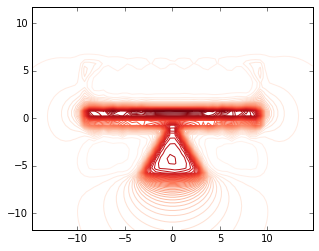

In [12]:
# isocontour plot of the DC potential
result0 = Result.from_vtk(prefix, "RF")
result1 = Result.from_vtk(prefix, "DC5")
result2 = Result.from_vtk(prefix, "DC2")
result3 = Result.from_vtk(prefix, "DC3")
p0 = result0.pseudo_potential
p1, p2, p3 = result1.potential, result2.potential, result3.potential
strength = np.amax(p1)/np.amax(p0)    # This is a factor ratio between DC and RF electrode.
p = strength*p0+p1+p2+p3
maxp = np.amax(p)
print "p max", maxp
x = grid.to_mgrid()[:,:,:,p.shape[2]/2]
p = p[:,:,p.shape[2]/2]
print "xy plane, superposition"
fig, ax = plt.subplots()
ax.set_aspect("equal")
ax.contour(x[0], x[1], p, levels=np.linspace(0, maxp, 50), cmap=plt.cm.Reds)

p max 0.64181
yz plane


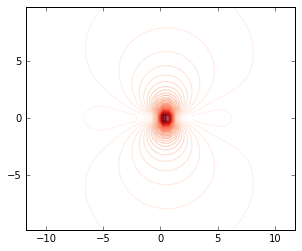

In [13]:
# isocontour plot of the DC potential
result = Result.from_vtk(prefix, "DC5")
p = result.potential
maxp = np.amax(p)
print "p max", maxp
x = grid.to_mgrid()[:,p.shape[0]/2]
p = p[p.shape[0]/2]
print "yz plane"
fig, ax = plt.subplots()
ax.set_aspect("equal")
ax.contour(x[1], x[2], p, levels=np.linspace(0, maxp, 50), cmap=plt.cm.Reds)    # 2e-2

p max 0.847068
yz plane


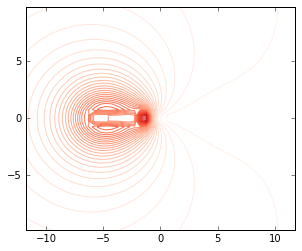

In [14]:
# isocontour plot of the DC potential
result = Result.from_vtk(prefix, "DC3")
p = result.potential
maxp = np.amax(p)
print "p max", maxp
x = grid.to_mgrid()[:,p.shape[0]/2]
p = p[p.shape[0]/2]
print "yz plane"
fig, ax = plt.subplots()
ax.set_aspect("equal")
ax.contour(x[1], x[2], p, levels=np.linspace(0, maxp, 50), cmap=plt.cm.Reds)

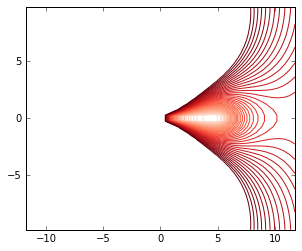

In [15]:
# isocontour plot of the DC potential
result = Result.from_vtk(prefix, "DC3")
p = result.potential
x = grid.to_mgrid()[:,p.shape[0]/2]
p = p[p.shape[0]/2]
fig, ax = plt.subplots()
ax.set_aspect("equal")
ax.contour(x[1], x[2], p, levels=np.linspace(0, 2e-2, 50), cmap=plt.cm.Reds)

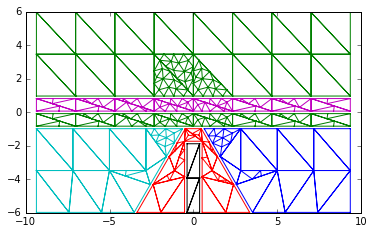

In [16]:
fig, ax = plt.subplots(subplot_kw=dict(aspect="equal"))
mesh.plot(ax)

In [ ]:
# explore it in fancy 3D
# fire up a mayavi2 window showing base mesh, charges on final mesh
# and isosurfaces of the pseudopotential
Result.view(prefix, "RF")
# need to start the full eventloop for the window.
# close it to return control to the notebook
from pyface.api import GUI
GUI().start_event_loop()

In [17]:
from electrode import System, GridElectrode

# load the electrostatics results into a electrode.System()
s = System()
for name in "DC1 DC2 DC3 DC4 DC5 RF".split():
    r = Result.from_vtk(prefix, name)
    e = GridElectrode.from_result(r)
    e.name = name
    s.append(e)
s["RF"].rf = 1.

ImportError: No module named electrode

In [18]:
from scipy.constants import atomic_mass
x0 = s.minimum((0, 0, 1.))
for _ in s.analyze_static(x0, m=25*atomic_mass, u=50.,
                          l=40e-6, o=100e6*2*np.pi):
    print _

AttributeError: 'float' object has no attribute 'minimum'

In [19]:
n = 30
#xyz = np.mgrid[-.1:.1:1j*n, -.1:.1:1j*n, 1.12:2]
#xyz = np.mgrid[0:1, -.02:.02:1j*n, .5:1.5:1j*n]
xyz = grid.to_mgrid()
p = s.potential(xyz.reshape(3, -1).T, 0).reshape(xyz[0].shape)
v = np.linspace(0, 2e-2, 21)
fig, ax = plt.subplots()
ax.set_aspect("equal")
ax.contour(xyz[1, 10, :, :], xyz[2, 10, :, :], p[10, :, :], v, cmap=plt.cm.Reds_r)

AttributeError: 'float' object has no attribute 'potential'